In [1]:
from qiskit import QuantumCircuit, execute, Aer, transpile, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import MCMT
import qiskit
import numpy as np

In [2]:
# The problem statement
s = [5,7,8,9,1]
w = 16

In [3]:
# Scale the values of the array and target
norm = sum(s) + w
w_prime = -w / norm

thetas = []
thetas.append(w_prime)

for e in s:
    thetas.append(e / norm)
    
print("Thetas = ", thetas)

Thetas =  [-0.34782608695652173, 0.10869565217391304, 0.15217391304347827, 0.17391304347826086, 0.1956521739130435, 0.021739130434782608]


In [4]:
t = int(np.ceil(np.log2(norm)))
n = len(s)
qubits_total = t + len(s) + 1

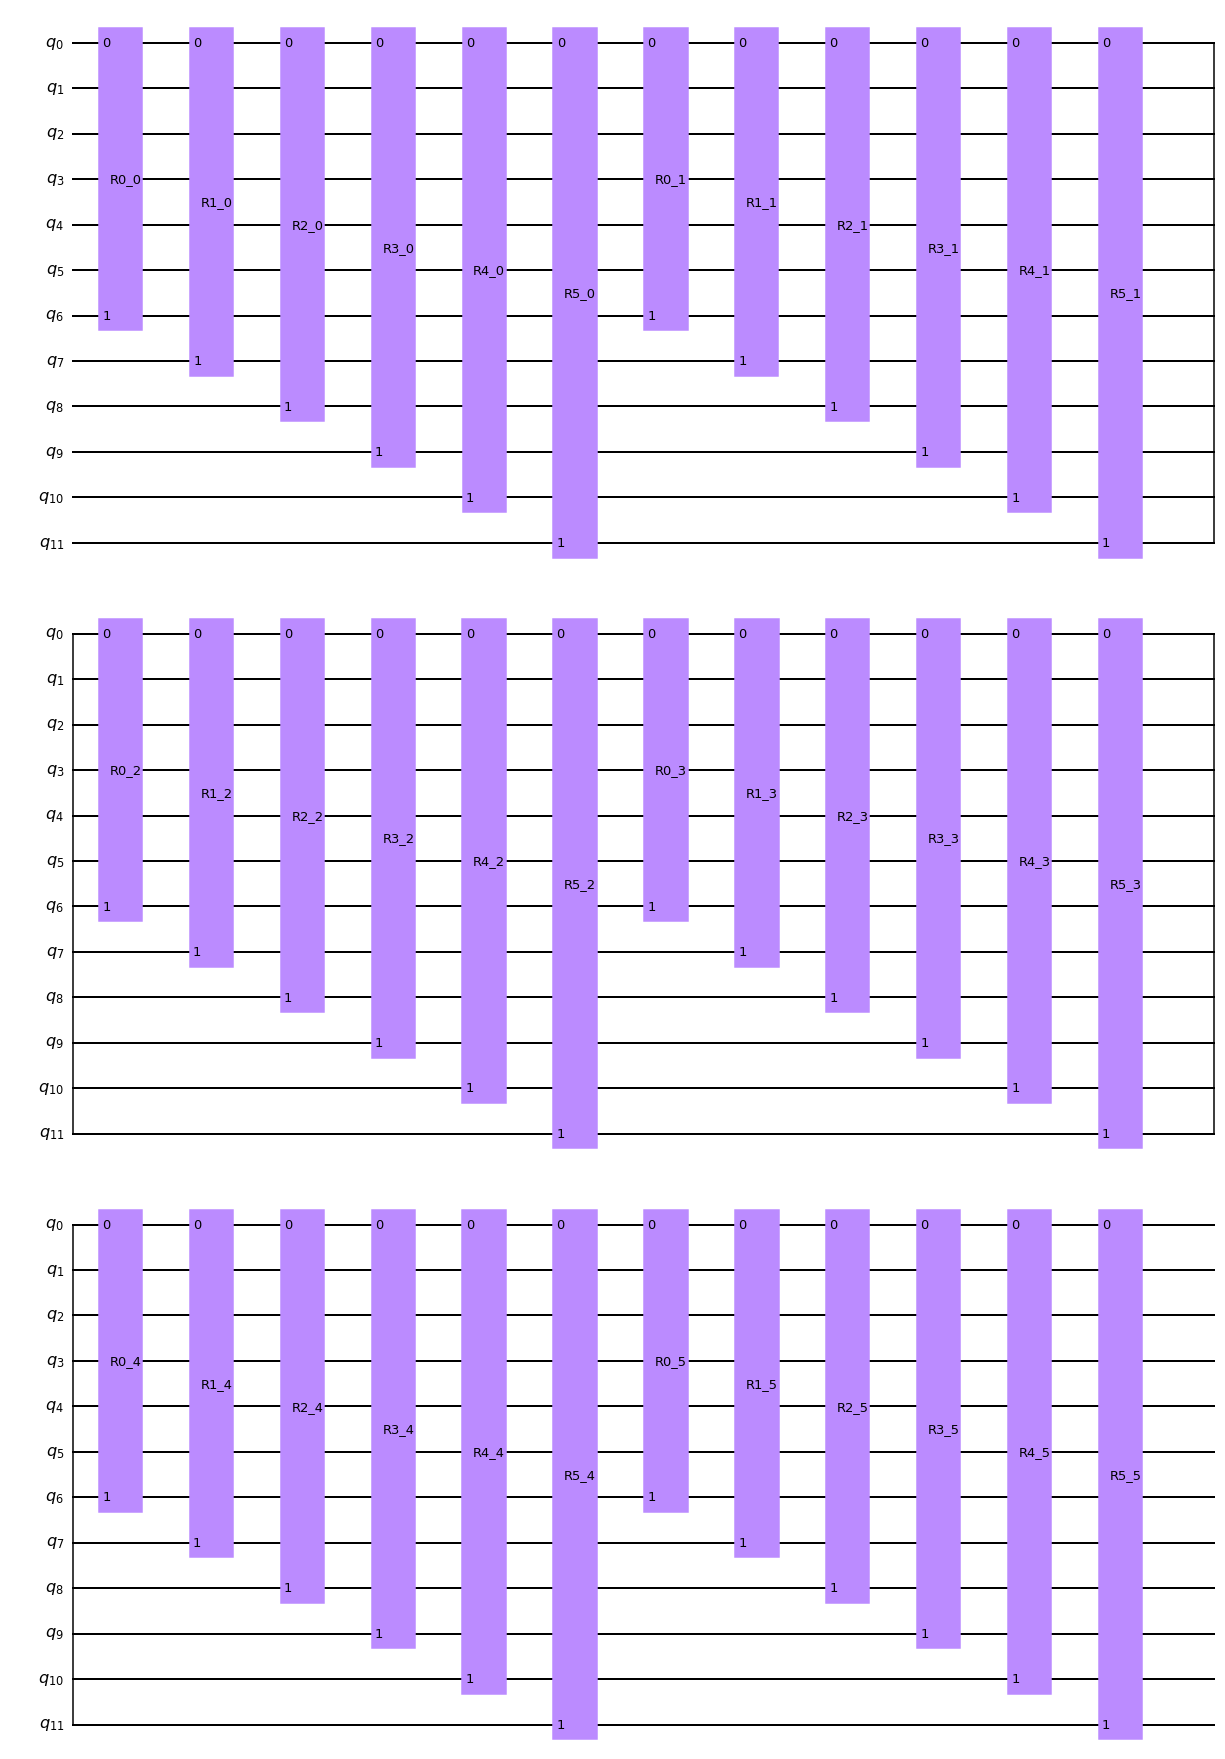

In [5]:
# Generate CU^(2^j) operator
cU = QuantumCircuit(qubits_total)
phase_gate = qiskit.circuit.library.CPhaseGate
for i in range(t):
    for j in range(n+1):
        P = phase_gate(2*np.pi * thetas[j]).power(2**i)
        P.label = "R" + str(j) + "_" + str(i)
        cU.append(P,[0,t+j])   
        
cU.name="CU^(2^t)"
cU.draw('mpl')

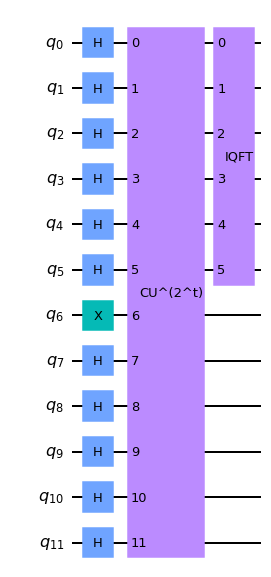

In [6]:
# generate U of Quantum Phase Estimation
U_QPE = QuantumCircuit(qubits_total)
# Apply hadamard to first t qubits
for i in range(t):
    U_QPE.h(i)
U_QPE.x(t)
for j in range(t+1, qubits_total):
    U_QPE.h(j)

U_QPE.append(cU,range(qubits_total))

# Add QFT.Inverse to the back
QFT_I = qiskit.circuit.library.QFT(num_qubits=t, inverse=True)
U_QPE.append(QFT_I, range(t))
U_QPE.name ='U_qpe'
U_QPE.draw('mpl')

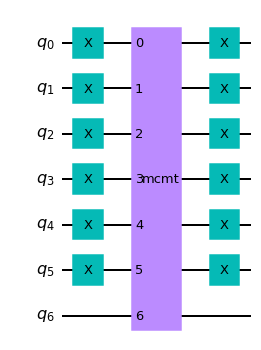

In [7]:
# Now that the QPE circuit is done we use Amplitude Amplification to find the |0> vector
U_f = QuantumCircuit(t+1)

for i in range(t):
    U_f.x(i)
    
CnZ = MCMT('z', num_ctrl_qubits=t,num_target_qubits=1)
# CnZ.draw("mpl")
U_f.append(CnZ, range(0, t+1))

for i in range(t):
    U_f.x(i)
U_f.name = 'U_f'
U_f.draw('mpl')

[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 6]


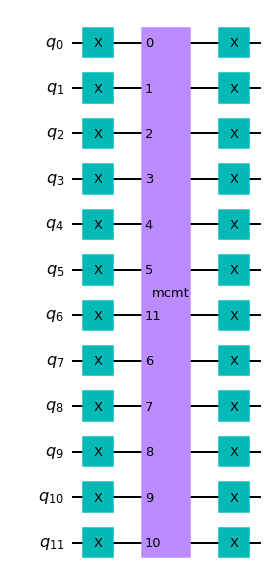

In [8]:
# Generate U_s operator
U_s = QuantumCircuit(qubits_total)

for i in range(qubits_total):
    U_s.x(i)
    
CnZ_2 = MCMT('z', num_ctrl_qubits=t+n,num_target_qubits=1)
qbit_list = []
for i in range(qubits_total):
    if i != t:
        qbit_list.append(i)
qbit_list.append(t)
U_s.append(CnZ_2, qbit_list)
print(qbit_list)
for i in range(qubits_total):
    U_s.x(i)
U_s.name = "U_s"    
U_s.draw('mpl')

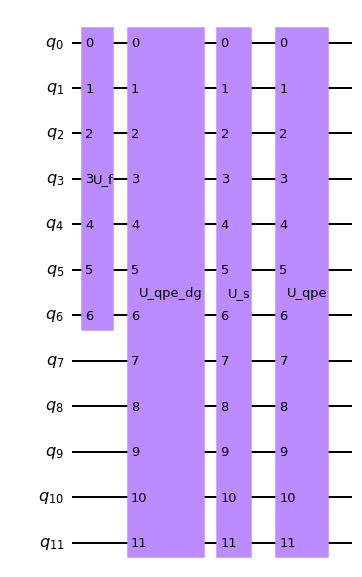

In [9]:
# Now that we have all the components for the circuit, we can construct the circuit in full
# First lets make the AA circuit:
AA = QuantumCircuit(qubits_total)

AA.append(U_f,range(t+1))
AA.append(U_QPE.inverse(), range(qubits_total))
AA.append(U_s, range(qubits_total))
AA.append(U_QPE, range(qubits_total))

AA.name = "AA"
AA.draw('mpl')

In [10]:
# We need to repeat the circuit Sqrt(N/M) times where in the example M = 2 where 
# there are 2 possible subsets out of 2^5 combinations
M = 2
N = 2 ** n
itr = int(np.ceil(np.sqrt(N/M)))
print("Number of iterations = ", itr)

Number of iterations =  4


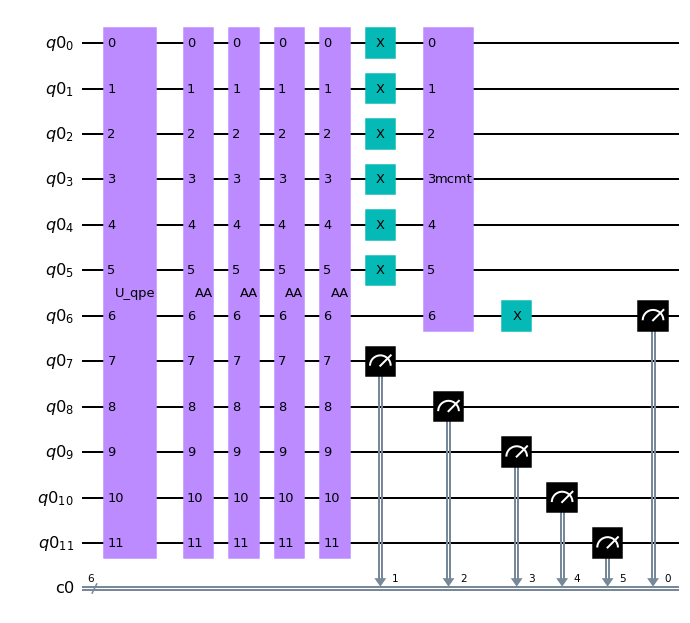

In [11]:
Cl_reg = ClassicalRegister(n + 1)
Qn_reg = QuantumRegister(qubits_total)
subset_sum = QuantumCircuit(Qn_reg, Cl_reg)

# first add the QPE circuit:
subset_sum.append(U_QPE, range(qubits_total))

#Then repeat the AA circuit Sqrt(N/M) times:
for i in range(itr):
    subset_sum.append(AA, range(qubits_total))
    
# Add measurement circuit:
for j in range(t):
    subset_sum.x(j)
    
CnX = MCMT('x', num_ctrl_qubits=t, num_target_qubits=1)
subset_sum.append(CnX, range(t+1))
subset_sum.x(t)

subset_sum.measure(range(t, qubits_total), Cl_reg)
subset_sum.draw('mpl')

In [12]:
backend = Aer.get_backend('qasm_simulator')
job_sim = backend.run(transpile(subset_sum, backend), shots=8192)
result_sim = job_sim.result()

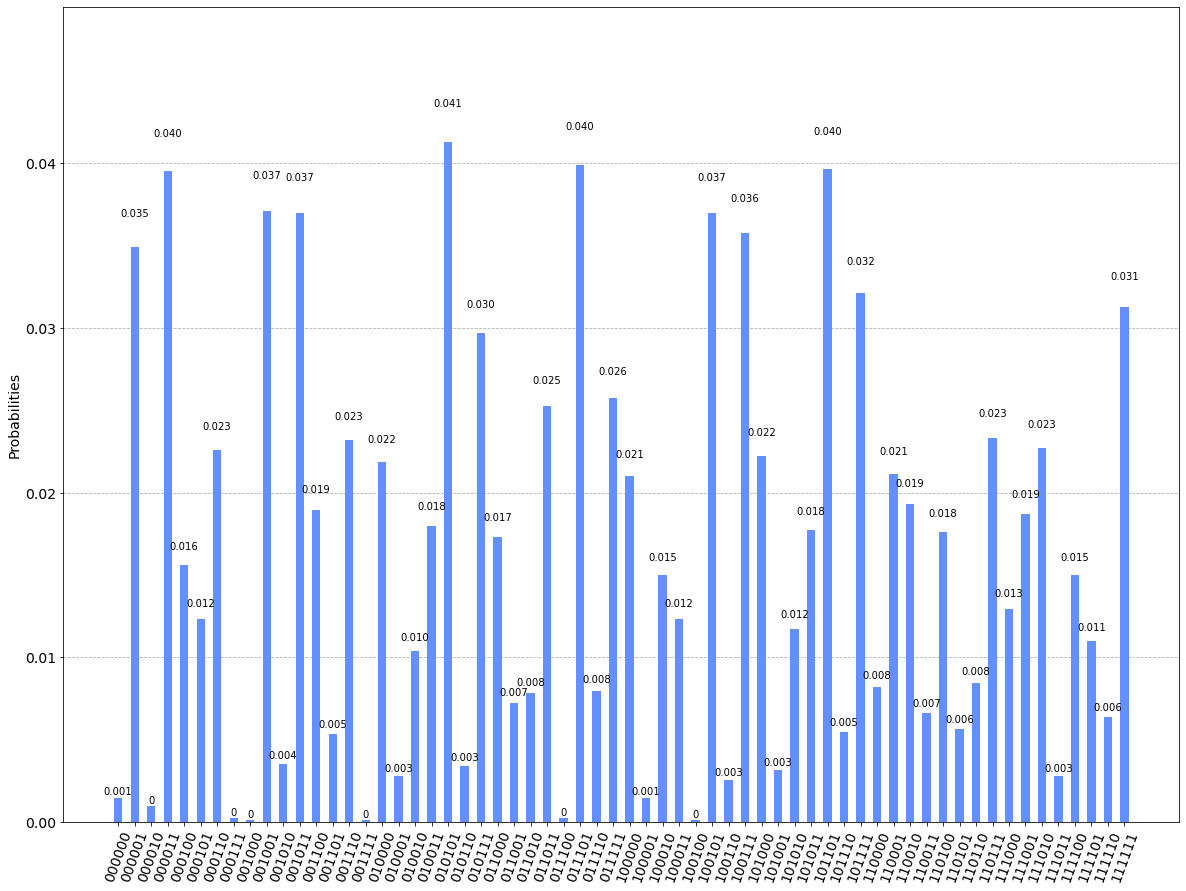

In [13]:
counts = result_sim.get_counts(subset_sum)
from qiskit.visualization import plot_histogram
plot_histogram(counts,figsize=(20, 15))

In [14]:
# Sort the counts to find the solution with the highest probability and Qubit6 (t-th qubit) must be 1
counts_list  = dict(sorted(counts.items(), key=lambda item: item[1]))
print(counts_list)

{'001000': 1, '100100': 1, '001111': 1, '000111': 2, '011100': 2, '000010': 8, '100001': 12, '000000': 12, '100110': 21, '111011': 23, '010001': 23, '101001': 26, '010110': 28, '001010': 29, '001101': 44, '101110': 45, '110101': 46, '111110': 52, '110011': 54, '011001': 59, '011010': 64, '011110': 65, '110000': 67, '110110': 69, '010010': 85, '111101': 90, '101010': 96, '000101': 101, '100011': 101, '111000': 106, '100010': 123, '111100': 123, '000100': 128, '011000': 142, '110100': 144, '101011': 145, '010011': 147, '111001': 153, '001100': 155, '110010': 158, '100000': 172, '110001': 173, '010000': 179, '101000': 182, '000110': 185, '111010': 186, '001110': 190, '110111': 191, '011011': 207, '011111': 211, '010111': 243, '111111': 256, '101111': 263, '000001': 286, '100111': 293, '100101': 303, '001011': 303, '001001': 304, '000011': 324, '101101': 325, '011101': 327, '010101': 338}


In [15]:
soln = max(counts_list, key=counts_list.get)[::-1] # Since in qiskit the qubit order is revserse
print("Value of the t-th qubit = ",soln[0])
soln_vec = soln[1:len(soln)]
print(soln_vec)

Value of the t-th qubit =  1
01010
